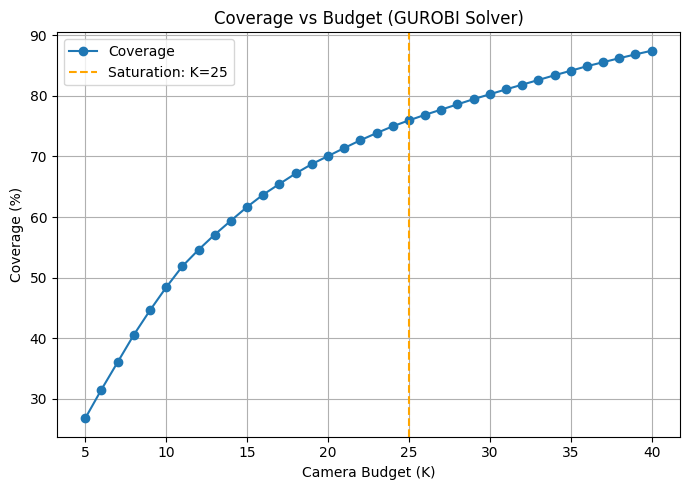

📌 Saturation point: K = 25, Coverage = 75.95%

📊 Coverage Table with Marginal Gains:

+----+---------------+------------+--------------+
| K  | Cells Covered | Coverage % | ∆ Coverage % |
+----+---------------+------------+--------------+
| 5  |      932      |   26.78%   |      -       |
| 6  |     1097      |   31.52%   |    4.74%     |
| 7  |     1254      |   36.03%   |    4.51%     |
| 8  |     1411      |   40.55%   |    4.51%     |
| 9  |     1552      |   44.60%   |    4.05%     |
| 10 |     1684      |   48.39%   |    3.79%     |
| 11 |     1805      |   51.87%   |    3.48%     |
| 12 |     1900      |   54.60%   |    2.73%     |
| 13 |     1987      |   57.10%   |    2.50%     |
| 14 |     2067      |   59.40%   |    2.30%     |
| 15 |     2146      |   61.67%   |    2.27%     |
| 16 |     2217      |   63.71%   |    2.04%     |
| 17 |     2278      |   65.46%   |    1.75%     |
| 18 |     2338      |   67.18%   |    1.72%     |
| 19 |     2392      |   68.74%   |    1.55%   

In [17]:
import pickle
import matplotlib.pyplot as plt
from tabulate import tabulate

# Load results and metadata
with open("GUROBI_merged.pkl", "rb") as f:
    data = pickle.load(f)

results = data["results"]
num_cells = data["num_cells"]

# Filter and sort
results = [r for r in results if r[2] is not None]
results.sort(key=lambda x: x[0])

Ks = [r[0] for r in results]
coverages = [r[1] for r in results]
percent_coverage = [100 * c / num_cells for c in coverages]

# Compute marginal gains
marginal_gains = [None] + [j - i for i, j in zip(percent_coverage[:-1], percent_coverage[1:])]

# Define threshold for saturation
SATURATION_THRESHOLD = 1.0

# Find saturation point
saturation_idx = next((i for i, g in enumerate(marginal_gains) if g is not None and g < SATURATION_THRESHOLD), None)
saturation_K = Ks[saturation_idx] if saturation_idx is not None else None
saturation_cov = percent_coverage[saturation_idx] if saturation_idx is not None else None

# Plot
plt.figure(figsize=(7, 5))
plt.plot(Ks, percent_coverage, marker='o', label='Coverage')
if saturation_K:
    plt.axvline(saturation_K, color='orange', linestyle='--', label=f'Saturation: K={saturation_K}')
plt.xlabel("Camera Budget (K)")
plt.ylabel("Coverage (%)")
plt.title("Coverage vs Budget (GUROBI Solver)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("solver_coverage_plot_saturation.png")
plt.show()

# Print saturation details
if saturation_K:
    print(f"📌 Saturation point: K = {saturation_K}, Coverage = {saturation_cov:.2f}%")
else:
    print("❗ Saturation point not found (no gain drops below threshold)")

# Generate table with marginal gain
table_data = []
for k, cov, pcov, gain in zip(Ks, coverages, percent_coverage, marginal_gains):
    gain_str = f"{gain:.2f}%" if gain is not None else "-"
    if gain is not None and gain < SATURATION_THRESHOLD:
        gain_str += " 🔻"
    table_data.append([k, cov, f"{pcov:.2f}%", gain_str])

print("\n📊 Coverage Table with Marginal Gains:\n")
print(tabulate(table_data, headers=["K", "Cells Covered", "Coverage %", "∆ Coverage %"], tablefmt="pretty"))


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from kneed import KneeLocator
import os
import pickle

# Parameters
MAX_RANGE = 25
CONE_ANGLE = 90

# Optional: Set this to override automatic K selection
custom_K = 40  # Set to None to use elbow method

# Load reduced results and metadata
with open("GUROBI_merged.pkl", "rb") as f:
    data = pickle.load(f)

results = data["results"]
num_cells = data["num_cells"]
cam_map = data["cam_map"]  # reduced index → full index
npz_file = data["npz_file"]  # original .npz file used

# Extract best K via elbow or use custom
valid_results = [r for r in results if r[2] is not None]
Ks = [r[0] for r in valid_results]
coverages = [r[1] for r in valid_results]
percent_coverage = [100 * c / num_cells for c in coverages]

if custom_K is not None:
    if custom_K in Ks:
        optimal_K = custom_K
        print(f"🛠️ Using custom K = {optimal_K}")
    else:
        raise ValueError(f"Custom K = {custom_K} is not available in the results. Available Ks: {Ks}")
else:
    if len(Ks) == 1:
        optimal_K = Ks[0]
        print(f"📌 Only one K value present. Using K = {optimal_K}")
    else:
        knee = KneeLocator(Ks, percent_coverage, curve='concave', direction='increasing')
        optimal_K = knee.knee
        if optimal_K is None:
            optimal_K = Ks[np.argmax(percent_coverage)]
            print(f"⚠️ No elbow detected. Using max coverage K = {optimal_K}")
        else:
            print(f"🎯 Using elbow solution: K = {optimal_K} (Coverage = {knee.knee_y:.2f}%)")

# Get x.value from the selected solution
matching = [r for r in valid_results if r[0] == optimal_K]
if not matching:
    raise ValueError(f"No solution found for optimal K = {optimal_K}")
K, _, x_val_reduced = matching[0]

# Load original full camera positions
data_full = np.load(npz_file, allow_pickle=True)
camera_positions_full = data_full["camera_positions"]

# Map reduced x_val back to full-size solution
selected_reduced = [i for i in range(len(x_val_reduced)) if x_val_reduced[i] > 0.5]
selected_full_indices = cam_map[selected_reduced]
selected_positions = [camera_positions_full[i] for i in selected_full_indices]

# Load room grids
room_grids = {
    fname.replace("_grid.npy", ""): np.load(f"Selected_Rooms/{fname}")
    for fname in os.listdir("Selected_Rooms") if fname.endswith("_grid.npy")
}

# Create output folder
os.makedirs("Results_Overlay_40", exist_ok=True)

# Group cameras by room
room_to_cameras = {}
for (room, cam) in selected_positions:
    room_to_cameras.setdefault(room, []).append(cam)

# Generate visual overlays
for room, cams in room_to_cameras.items():
    grid = room_grids[room]
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(grid, cmap="gray_r")

    vis_path = f"Selected_Rooms/{room}_conical_visibility.npz"
    vis_data = np.load(vis_path, allow_pickle=True)

    for (i, j, theta) in cams:
        ax.plot(j, i, 'ro')
        cone_start = (theta - 45) % 360
        wedge = Wedge(center=(j, i), r=MAX_RANGE, theta1=cone_start,
                      theta2=(cone_start + CONE_ANGLE) % 360,
                      edgecolor='blue', facecolor='skyblue', alpha=0.15)
        ax.add_patch(wedge)

        key = str((i, j, theta))
        if key in vis_data:
            visible = [tuple(x) for x in vis_data[key]]
            for vi, vj in visible:
                if grid[vi, vj] == 0:
                    ax.plot(vj, vi, 's', color='deepskyblue', alpha=0.5, markersize=1.5)

    ax.set_title(f"Optimal Camera Placements in {room} (K={K})")
    ax.axis('off')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.savefig(f"Results_Overlay_40/{room}_K={K}.png", bbox_inches='tight', dpi=200)
    plt.close()

print(f"✅ Overlays saved to Results_Overlay_40/ for K = {K}")


🛠️ Using custom K = 40
✅ Overlays saved to Results_Overlay_40/ for K = 40
